### (0) Overview
The objective of this code is to implement an automaker's profit maximization in pyomo & ipopt. The implementation for an automaker with 3 vehicles (1 EV, 2 ICE) starts with the simplest forms of the problem with only price variables and builds towards a formulation with demand, variables for price and design, and constraints for ghg and design.

In [1]:
# !pip install pyomo # if needed
# !pip install pandas
# ! pip install matplotlib
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
import time
from dataclasses import dataclass

# Single Automaker

## 1: Price Variable Examples

### (a) Profit w/o Demand

min: $\pi_k = \sum_{j \in J_k} (p_j - c_j )$

wrt: $p_j  \ \forall j \in J$

In [2]:
model = pyo.AbstractModel() # Declare model

# Declare problem parameters (number of vehicles, tech pkgs, etc.)
model.n_vehicles = pyo.Param(within=pyo.NonNegativeIntegers) # Number of vehicles

# Declare sets (1...n)
model.vehicle_set = pyo.RangeSet(1,model.n_vehicles) # Set of vehicles

# Declare parameters
model.vehicle_costs = pyo.Param(model.vehicle_set) # Cost params (for each vehicle)

# Declare decision vars
model.vehicle_prices = pyo.Var(model.vehicle_set, domain=pyo.NonNegativeReals, bounds=(0,100)) # Matching/indexed by set J, of size n_vehicles

# Define objective
def obj(model):
    profit = sum((model.vehicle_prices[vehicle_id] - model.vehicle_costs[vehicle_id]) for vehicle_id in model.vehicle_set)
    return profit

model.obj = pyo.Objective(rule=obj, sense=pyo.maximize)

# Define instance
dummy_vehicle_data = {None: {                     # none required entry
    'n_vehicles': {None: 3},               # scalars must have none
    'vehicle_costs': {1: 10, 2: 15, 3: 20}
}}

# Create an instance of the model
instance = model.create_instance(dummy_vehicle_data)

solver = pyo.SolverFactory('ipopt',executable='C:\\Ipopt\\bin\\ipopt.exe')
results = solver.solve(instance)
print(results)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 3
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.03440117835998535
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


### (b) Profit w/  Demand

min: $\pi = \sum_{j \in J} q_j (p_j - c_j )$

wrt: $p_j  \ \forall j \in J$

where: $v_j = \beta_p * p_j$ \
$q_j = \frac{\exp(v_j)}{\sum_{l \in J}\exp(v_l)+v_{og}}*m$

In [3]:
model = pyo.AbstractModel() # declare model

# Declare problem parameters (number of vehicles, tech pkgs, etc.)
model.n_vehicles = pyo.Param(within=pyo.NonNegativeIntegers) # Declare number of vehicles

# Declare sets (1...n)
model.vehicle_set = pyo.RangeSet(1,model.n_vehicles) # Declare set of vehicles
# have incosistent length of tech packages

# Declare parameters
model.vehicle_costs = pyo.Param(model.vehicle_set) # Declare cost param for each vehicle
model.preference_parameters = pyo.Param() # utility
model.og_utility = pyo.Param()
model.market_size = pyo.Param()

# Declare decision vars
model.vehicle_prices = pyo.Var(model.vehicle_set, domain=pyo.NonNegativeReals, bounds=(0,100)) # Matching/indexed by set J, of size n_vehicles

# Supplemental Functions
def utility_rule(model,vehicle_id):
    utilities = model.preference_parameters * model.vehicle_prices[vehicle_id]
    return utilities

def demand_rule(model,vehicle_id):
    vehicle_demand = pyo.exp(model.utilities[vehicle_id]) / (sum(pyo.exp(model.utilities[i])for i in model.vehicle_set) + pyo.exp(model.og_utility)) * model.market_size
    return vehicle_demand

# Define intermediate vars
model.utilities = pyo.Expression(model.vehicle_set, rule = utility_rule)  # Calculate utility
model.vehicle_demand = pyo.Expression(model.vehicle_set, rule = demand_rule)   # Caluclate demand

# Define objective
def profit_rule(model):
    profit = sum(model.vehicle_demand[vehicle_id]*(model.vehicle_prices[vehicle_id] - model.vehicle_costs[vehicle_id]) for vehicle_id in model.vehicle_set)
    return profit

model.obj = pyo.Objective(rule=profit_rule, sense=pyo.maximize)

# Define instance
dummy_vehicle_data = {None: {                     # none required entry
    'n_vehicles': {None: 3},               # scalars must have none
    'preference_parameters': {None: -0.1},           # pref param
    'og_utility': {None: 0},              # outside good utility
    'market_size': {None: 1},
    'vehicle_costs': {1: 10, 2: 15, 3: 20}
}}

# Create an instance of the model
instance = model.create_instance(dummy_vehicle_data)

solver = pyo.SolverFactory('ipopt',executable='C:\\Ipopt\\bin\\ipopt.exe')
results = solver.solve(instance,report_timing=True)
print(results)

# Access the value of the objective function
print("Objective value:", pyo.value(instance.obj))

# Access the value of decision variables
for vehicle_id in instance.vehicle_set:
    print(f"vehicle_prices[{vehicle_id}]:", pyo.value(instance.vehicle_prices[vehicle_id]))


        0.00 seconds required to write file
        0.00 seconds required for presolve
        0.05 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file
        0.00 seconds required for postsolve

Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 3
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.04531598091125488
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Objective value: 2.1542271863238827
vehicle_prices[1]: 22.154227195338724
vehicle_prices[2]: 27.1542271969544
vehicle_prices[3]: 32.154227198737885


### (c) Profit w/ Price, Demand, and GHG Constraint

min: $\pi = \sum_{j \in J} q_j (p_j - c_j )$

wrt: $p_j  \ \forall j \in J$

st:  $ \sum_{j \in J} \ ( g_j -t_j )* q_j \leq 0$

where: $v_j = \beta_p * p_j$ \
$q_j = \frac{\exp(v_j)}{\sum_{l \in J}\exp(v_l)+v_{og}}*m$

In [4]:
model = pyo.AbstractModel() # declare model

# Declare problem parameters (number of vehicles, tech pkgs, etc.)
model.n_vehicles = pyo.Param(within=pyo.NonNegativeIntegers) # Declare number of vehicles

# Declare sets (1...n)
model.vehicle_set = pyo.RangeSet(1,model.n_vehicles) # Declare set of vehicles
# have incosistent length of tech packages

# Declare parameters
model.vehicle_costs = pyo.Param(model.vehicle_set)        # Declare cost param for each vehicle
model.ghgs = pyo.Param(model.vehicle_set)         # real ghgs
model.target_ghgs = pyo.Param(model.vehicle_set)  # target ghgs
model.preference_parameters = pyo.Param()                # utility
model.og_utility = pyo.Param()                # outside good utility
model.market_size = pyo.Param()               # market size

# Declare decision vars
model.vehicle_prices = pyo.Var(model.vehicle_set, domain=pyo.NonNegativeReals, bounds=(0,100)) # Matching/indexed by set J, of size n_vehicles

# Supplemental Functions
def utility_rule(model,vehicle_id):
    utilities = model.preference_parameters * model.vehicle_prices[vehicle_id]
    return utilities

def demand_rule(model,vehicle_id):
    vehicle_demand = pyo.exp(model.utilities[vehicle_id]) / (sum(pyo.exp(model.utilities[denom_v])for denom_v in model.vehicle_set) + pyo.exp(model.og_utility)) * model.market_size
    return vehicle_demand

def vehicle_profits_rule(model,vehicle_id):
    vehicle_profits = model.vehicle_demand[vehicle_id]*(model.vehicle_prices[vehicle_id] - model.vehicle_costs[vehicle_id])
    return vehicle_profits

# Define intermediate vars
model.utilities = pyo.Expression(model.vehicle_set, rule = utility_rule)         # Calculate utility
model.vehicle_demand = pyo.Expression(model.vehicle_set, rule = demand_rule)              # Caluclate demand
model.vehicle_profits = pyo.Expression(model.vehicle_set, rule = vehicle_profits_rule)   # Caluclate profits of each veh

# Define objective
def profit_rule(model):
    pi = sum(model.vehicle_profits[vehicle_id] for vehicle_id in model.vehicle_set)
    return pi

def ghg_rule(model):
    swa_ghg = sum(model.ghgs[vehicle_id]*model.vehicle_demand[vehicle_id] for vehicle_id in model.vehicle_set)
    swa_target = sum(model.target_ghgs[vehicle_id]*model.vehicle_demand[vehicle_id] for vehicle_id in model.vehicle_set)
    return swa_ghg  - swa_target <= 0

# Setup optimization
model.obj = pyo.Objective(rule=profit_rule, sense=pyo.maximize)
model.ghg_con = pyo.Constraint(rule=ghg_rule)

# Define instance
dummy_vehicle_data = {None: {                           # none required entry
    'n_vehicles': {None: 3},                  # scalars must have none
    'preference_parameters': {None: -0.1},           # pref param
    'og_utility': {None: 0},              
    'market_size': {None: 1},
    'vehicle_costs': {1: 20, 2: 10, 3: 15},
    'ghgs': {1: 0, 2: 100, 3: 200},
    'target_ghgs': {1: 100, 2: 100, 3: 100}
}}

# Solve instance
instance = model.create_instance(dummy_vehicle_data)
solver = pyo.SolverFactory('ipopt',executable='C:\\Ipopt\\bin\\ipopt.exe')
results = solver.solve(instance) #,report_timing=True)
print(results)

# Print results
print("Profit:", pyo.value(instance.obj))
# instance.vehicle_prices.pprint()
results_list = []
for vehicle_id in instance.vehicle_set:
    price = pyo.value(instance.vehicle_prices[vehicle_id])
    ghg_rate = instance.ghgs[vehicle_id]
    vehicle_demand = pyo.value(instance.vehicle_demand[vehicle_id])
    results_list.append({"Vehicle": vehicle_id, "Price": price, "ghg_rate": ghg_rate, "Demand": vehicle_demand})
results_df = pd.DataFrame(results_list)
results_df['Price'] = results_df['Price'].round(3)
print(results_df)



Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1
  Number of variables: 3
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.042203426361083984
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Profit: 2.127521500861694
   Vehicle   Price  ghg_rate    Demand
0        1  29.628         0  0.042611
1        2  22.128       100  0.090207
2        3  29.628       200  0.042611


## 2: Design Variable Examples

These get a little more tricky, since having design with variable technology packages for each vehicle $x_{ij} \ \forall i \in I_j \ \forall j \in J$ requires putting sets within a set, aka sparse index sets. See [the section Sparces https://pyomo.readthedocs.io/en/stable/pyomo_modeling_components/Sets.html for ](https://pyomo.readthedocs.io/en/stable/pyomo_modeling_components/Sets.html) for additional detail. 

Since a nested dictionary is needed to create a concrete instance with the sparce index set, I am going to define custom class datastructres to store the dictionaries & populate dummy dummy_vehicle_data

### (a) Custom Dataclasses

In [5]:
# Generate classes to store dummy_vehicle_data

@dataclass      # decorator avoids having to define properties in definition
class Technology:
    technology_id: str
    cost: float
    ghg_rate: float

@dataclass
class Vehicle:
    vehicle_id: str
    technologies: list[Technology]
    price: float
    target_ghg_rate: float
    # cost: Optional(float)  # will have to import optional

# @ dataclass
# class Automaker:
#     automaker_id: str
#     vehicles: list[Vehicle]

In [6]:
# Generate dummy dummy_vehicle_data (asymmetrical to make fun)

vehicle_ids = ["EV", "ICE1", "ICE2"]
technology_ids = "ABC"
cost_constant = 10
ghg_constant = 3000

vehicles = []
for i, vehicle_id in enumerate(vehicle_ids):
    technologies = []
    for j,technology_id in enumerate(technology_ids[:i+1]):
        # technology_cost = cost_constant+j*5+(2-i)*5 + i*5
        if vehicle_id == "EV":
            technology_cost = 20
            technology_ghg_rate = 0
        else:
            technology_cost = cost_constant + j*5 + i*5 - 5
            technology_ghg_rate = 150 + 50*i - 50*j # (ghg_constant*i / technology_cost) / 2
        techonology = Technology(technology_id=technology_id, cost=technology_cost, ghg_rate = technology_ghg_rate)
        technologies.append(techonology)
    vehicle_price = technology_cost       # Highest tech cost
    vehicle_target_ghg_rate = 150
    vehicle = Vehicle(vehicle_id=vehicle_id, technologies=technologies, price=vehicle_price, target_ghg_rate=vehicle_target_ghg_rate)
    vehicles.append(vehicle)
vehicles

[Vehicle(vehicle_id='EV', technologies=[Technology(technology_id='A', cost=20, ghg_rate=0)], price=20, target_ghg_rate=150),
 Vehicle(vehicle_id='ICE1', technologies=[Technology(technology_id='A', cost=10, ghg_rate=200), Technology(technology_id='B', cost=15, ghg_rate=150)], price=15, target_ghg_rate=150),
 Vehicle(vehicle_id='ICE2', technologies=[Technology(technology_id='A', cost=15, ghg_rate=250), Technology(technology_id='B', cost=20, ghg_rate=200), Technology(technology_id='C', cost=25, ghg_rate=150)], price=25, target_ghg_rate=150)]

### (b) Profit w/ Design Only & Classes & No Demand

min: $\pi = \sum_{j \in J} (p_j - c_j )$

wrt: $ x_{ij}  \ \forall i \in I_j \ \forall j \in J$

st:  $ 1 - \sum_{i \in I_j} \ x_{ij} = 0 \ \forall j \in J$

where: $ c_j = \sum_{i \in I_j}  \omega_{ij} * x_{ij}$


In [7]:
# Define dummy_vehicle_data dict for instance
dummy_vehicle_data = {None: {
    'vehicle_set': {None: [vehicle.vehicle_id for vehicle in vehicles]},                            
    'technology_set': {vehicle.vehicle_id: [technology.technology_id for technology in vehicle.technologies] for vehicle in vehicles},           # index tech from vehicle set
    'technology_costs': {(vehicle.vehicle_id, technology.technology_id): technology.cost for vehicle in vehicles for technology in vehicle.technologies},
    'vehicle_prices': {vehicle.vehicle_id: vehicle.price for vehicle in vehicles}
}}

dummy_vehicle_data

{None: {'vehicle_set': {None: ['EV', 'ICE1', 'ICE2']},
  'technology_set': {'EV': ['A'], 'ICE1': ['A', 'B'], 'ICE2': ['A', 'B', 'C']},
  'technology_costs': {('EV', 'A'): 20,
   ('ICE1', 'A'): 10,
   ('ICE1', 'B'): 15,
   ('ICE2', 'A'): 15,
   ('ICE2', 'B'): 20,
   ('ICE2', 'C'): 25},
  'vehicle_prices': {'EV': 20, 'ICE1': 15, 'ICE2': 25}}}

In [8]:
# Build model
model = pyo.AbstractModel() # Declare model

# Declare problem parameters & sets
model.vehicle_set = pyo.Set()                                        # Set of vehicles
model.technology_set = pyo.Set(model.vehicle_set)                   # Set indexed by vehicle set

def init_vehicle_technology_set(model):     # initilize each technology set for each vehicle 
    return ((vehicle_id, technology_id) for vehicle_id in model.vehicle_set for technology_id in model.technology_set[vehicle_id])
model.vehicle_technology_set = pyo.Set(dimen=2, initialize=init_vehicle_technology_set)

model.technology_costs = pyo.Param(model.vehicle_technology_set, within=pyo.NonNegativeReals)                        # Cost params (for each vehicle)
# model.vehicle_costs = pyo.Param(model.vehicle_set, within=pyo.NonNegativeReals)                                      # Vehicle vehicle_costs
model.vehicle_prices = pyo.Param(model.vehicle_set, within=pyo.NonNegativeReals)                                             # Price params (for each vehicle)

# Declare decision vars
model.var_vehicle_technologies = pyo.Var(model.vehicle_technology_set, domain=pyo.NonNegativeReals, bounds=(0,1))   # Indexed by i,j ; technology_set within vehicles_set

# Define objective
def profit_rule(model):
    profit = sum((model.vehicle_prices[vehicle_id] - sum(model.technology_costs[(vehicle_id, technology_id)] * model.var_vehicle_technologies[(vehicle_id, technology_id)]
                                                  for technology_id in model.technology_set[vehicle_id])) for vehicle_id in model.vehicle_set)
    return profit


model.obj = pyo.Objective(rule=profit_rule, sense=pyo.maximize)

# Define constraint
def design_rule(model):
    return [1 - sum(model.var_vehicle_technologies[(vehicle_id, technology_id)] for technology_id in model.technology_set[vehicle_id]) == 0 for vehicle_id in model.vehicle_set]

model.design_rule = pyo.ConstraintList(rule=design_rule)

# Create an instance of the model
instance = model.create_instance(dummy_vehicle_data)

solver = pyo.SolverFactory('ipopt',executable='C:\\Ipopt\\bin\\ipopt.exe')
results = solver.solve(instance)
print(results)



Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 6
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.04681658744812012
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [9]:
# Print results
print("Profit:", pyo.value(instance.obj))
instance.var_vehicle_technologies.pprint()

Profit: 14.999999997614998
var_vehicle_technologies : Size=6, Index=vehicle_technology_set
    Key           : Lower : Value                  : Upper : Fixed : Stale : Domain
      ('EV', 'A') :     0 :                    1.0 :     1 : False : False : NonNegativeReals
    ('ICE1', 'A') :     0 :                    1.0 :     1 : False : False : NonNegativeReals
    ('ICE1', 'B') :     0 :                    0.0 :     1 : False : False : NonNegativeReals
    ('ICE2', 'A') :     0 :                    1.0 :     1 : False : False : NonNegativeReals
    ('ICE2', 'B') :     0 : 1.1925015727091593e-10 :     1 : False : False : NonNegativeReals
    ('ICE2', 'C') :     0 :                    0.0 :     1 : False : False : NonNegativeReals


### (c) Adding Demand & GHG Constraint

min: $\pi = \sum_{j \in J} (p_j - c_j )$

wrt: $ x_j  \ \forall j \in J$

st:  $ 1 - \sum_{i \in I_j} \ x_{ij} = 0 \ \forall j \in J$ \
$ \sum_{j \in J} \ ( g_j -t_j )* q_j \leq 0$

where: $ c_j = \sum_{i \in I_j}  \omega_{ij} * x_{ij}$ \
$v_j = \beta_p * p_j$ \
$q_j = \frac{\exp(v_j)}{\sum_{l \in J}\exp(v_l)+v_{og}}*m$


min: $\pi = \sum_{j \in J} q_j (p_j - c_j )$

wrt: $p_j  \ \forall j \in J$

st:  

where: 

In [10]:
# Define dummy_vehicle_data dict for instance
dummy_vehicle_data = {None: {
    'vehicle_set': {None: [vehicle.vehicle_id for vehicle in vehicles]},                            
    'technology_set': {vehicle.vehicle_id: [technology.technology_id for technology in vehicle.technologies] for vehicle in vehicles},           # index tech from vehicle set
    'technology_costs': {(vehicle.vehicle_id, technology.technology_id): technology.cost for vehicle in vehicles for technology in vehicle.technologies},
    'technology_ghg_rates': {(vehicle.vehicle_id, technology.technology_id): technology.ghg_rate for vehicle in vehicles for technology in vehicle.technologies},
    'vehicle_target_ghg_rates' : {vehicle.vehicle_id: vehicle.target_ghg_rate for vehicle in vehicles},
    'vehicle_prices': {vehicle.vehicle_id: vehicle.price for vehicle in vehicles},
    'preference_parameters': {None: -0.1},
    'og_utility': {None: 0},
    'market_size' : {None: 1}
}}
dummy_vehicle_data

{None: {'vehicle_set': {None: ['EV', 'ICE1', 'ICE2']},
  'technology_set': {'EV': ['A'], 'ICE1': ['A', 'B'], 'ICE2': ['A', 'B', 'C']},
  'technology_costs': {('EV', 'A'): 20,
   ('ICE1', 'A'): 10,
   ('ICE1', 'B'): 15,
   ('ICE2', 'A'): 15,
   ('ICE2', 'B'): 20,
   ('ICE2', 'C'): 25},
  'technology_ghg_rates': {('EV', 'A'): 0,
   ('ICE1', 'A'): 200,
   ('ICE1', 'B'): 150,
   ('ICE2', 'A'): 250,
   ('ICE2', 'B'): 200,
   ('ICE2', 'C'): 150},
  'vehicle_target_ghg_rates': {'EV': 150, 'ICE1': 150, 'ICE2': 150},
  'vehicle_prices': {'EV': 20, 'ICE1': 15, 'ICE2': 25},
  'preference_parameters': {None: -0.1},
  'og_utility': {None: 0},
  'market_size': {None: 1}}}

In [11]:
# Build model
model = pyo.AbstractModel()

# Define Sets
model.vehicle_set = pyo.Set()
model.technology_set = pyo.Set(model.vehicle_set)

# Initialize technology set
def init_vehicle_technology_set (model):
    return ((vehicle_id, technology_id) for vehicle_id in model.vehicle_set for technology_id in model.technology_set[vehicle_id])

model.vehicle_technology_set = pyo.Set(dimen=2, initialize=init_vehicle_technology_set)

# Define parameters
model.technology_costs = pyo.Param(model.vehicle_technology_set, within=pyo.NonNegativeReals)
model.technology_ghg_rates = pyo.Param(model.vehicle_technology_set, within=pyo.NonNegativeReals)
model.vehicle_prices = pyo.Param(model.vehicle_set, within=pyo.NonNegativeReals)
model.vehicle_target_ghg_rates = pyo.Param(model.vehicle_set, within=pyo.NonNegativeReals)
model.preference_parameters = pyo.Param() # utility
model.og_utility = pyo.Param()
model.market_size = pyo.Param()

# Define decision variables
model.var_vehicle_technologies = pyo.Var(model.vehicle_technology_set, domain=pyo.NonNegativeReals, bounds=(0,1))

# Supplementary rules
def vehicle_cost_rule(model,vehicle_id):
    vehicle_cost = sum(model.technology_costs[(vehicle_id, technology_id)] * model.var_vehicle_technologies[(vehicle_id, technology_id)]
                                                   for technology_id in model.technology_set[vehicle_id])
    return vehicle_cost

def vehicle_ghg_rate_rule(model,vehicle_id):
    vehicle_ghg_rate = sum(model.technology_ghg_rates[(vehicle_id, technology_id)] * model.var_vehicle_technologies[(vehicle_id, technology_id)]
                                                   for technology_id in model.technology_set[vehicle_id])
    return vehicle_ghg_rate

def vehicle_utility_rule(model,vehicle_id):
    utility = model.preference_parameters * model.vehicle_prices[vehicle_id]
    return utility

def vehicle_demand_rule(model,vehicle_id):
    vehicle_demand = pyo.exp(model.vehicle_utilities[vehicle_id]) / (sum(pyo.exp(model.vehicle_utilities[vehicle_id])for vehicle_id in model.vehicle_set) + pyo.exp(model.og_utility))
    return vehicle_demand

# Define intermediate vars
model.vehicle_costs = pyo.Expression(model.vehicle_set, rule = vehicle_cost_rule)
model.vehicle_ghg_rates = pyo.Expression(model.vehicle_set, rule = vehicle_ghg_rate_rule)
model.vehicle_utilities = pyo.Expression(model.vehicle_set, rule = vehicle_utility_rule)  # Calculate utility
model.vehicle_demands = pyo.Expression(model.vehicle_set, rule = vehicle_demand_rule)   # Caluclate demand

# # Define objective
def profit_rule(model):
    profit = sum((model.vehicle_prices[vehicle_id] - model.vehicle_costs[vehicle_id]) * model.vehicle_demands[vehicle_id] for vehicle_id in model.vehicle_set)
    return profit

model.obj = pyo.Objective(rule=profit_rule, sense=pyo.maximize)

# Define constraints
def design_rules(model):
    return [1 - sum(model.var_vehicle_technologies[(vehicle_id, technology_id)] for technology_id in model.technology_set[vehicle_id]) == 0 for vehicle_id in model.vehicle_set]

def swa_ghg_rule(model):
    total_sales = sum(model.vehicle_demands[vehicle_id] for vehicle_id in model.vehicle_set)
    swa_ghg_rate = sum(model.vehicle_ghg_rates[vehicle_id]*model.vehicle_demands[vehicle_id] for vehicle_id in model.vehicle_set) / total_sales
    swa_target_rate = sum(model.vehicle_target_ghg_rates[vehicle_id]*model.vehicle_demands[vehicle_id] for vehicle_id in model.vehicle_set) / total_sales
    return swa_ghg_rate  - swa_target_rate <= 0

model.con_design_rule = pyo.ConstraintList(rule=design_rules)
model.con_swa_ghg_rule = pyo.Constraint(rule=swa_ghg_rule)

# Create an instance of the model
instance = model.create_instance(dummy_vehicle_data)

solver = pyo.SolverFactory('ipopt',executable='C:\\Ipopt\\bin\\ipopt.exe')
results = solver.solve(instance)
print(results)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 6
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.045871734619140625
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [12]:
instance.var_vehicle_technologies.pprint()

# Print results
print("Profit:", pyo.value(instance.obj))
results_list = []
for vehicle_id in instance.vehicle_set:
    price = pyo.value(instance.vehicle_prices[vehicle_id])
    vehicle_costs = pyo.value(instance.vehicle_costs[vehicle_id])
    ghg_rate = pyo.value(instance.vehicle_ghg_rates[vehicle_id])
    vehicle_demand = pyo.value(instance.vehicle_demands[vehicle_id])
    results_list.append({"Vehicle": vehicle_id, "Price": price, "GHG Rate": ghg_rate, "Demand": vehicle_demand})
results_df = pd.DataFrame(results_list)
results_df['Price'] = results_df['Price'].round(3)
print(results_df)

results_swa_ghg = sum(pyo.value(instance.vehicle_ghg_rates[vehicle_id])*pyo.value(instance.vehicle_demands[vehicle_id]) for vehicle_id in instance.vehicle_set) \
    / sum(pyo.value(instance.vehicle_demands[vehicle_id])for vehicle_id in instance.vehicle_set)
print('SWA GHG Rate: ', results_swa_ghg)

var_vehicle_technologies : Size=6, Index=vehicle_technology_set
    Key           : Lower : Value                 : Upper : Fixed : Stale : Domain
      ('EV', 'A') :     0 :                   1.0 :     1 : False : False : NonNegativeReals
    ('ICE1', 'A') :     0 :                   1.0 :     1 : False : False : NonNegativeReals
    ('ICE1', 'B') :     0 :                   0.0 :     1 : False : False : NonNegativeReals
    ('ICE2', 'A') :     0 :    0.9999999956639873 :     1 : False : False : NonNegativeReals
    ('ICE2', 'B') :     0 : 8.408556031030956e-09 :     1 : False : False : NonNegativeReals
    ('ICE2', 'C') :     0 :                   0.0 :     1 : False : False : NonNegativeReals
Profit: 1.3442783550259154
  Vehicle  Price    GHG Rate    Demand
0      EV     20    0.000000  0.093947
1    ICE1     15  200.000000  0.154892
2    ICE2     25  250.000001  0.056982
SWA GHG Rate:  147.87700912895988


## 3: Price & Design Variable Examples

[All together now!](https://www.youtube.com/watch?v=73lj5qJbrms&t=45s)

### (a) Profit w/ Design & Price

min: $\pi = \sum_{j \in J} q_j (p_j - c_j )$

wrt: $p_j, x_{ij}  \ \ \forall i \in I_j \ \forall j \in J$

st:  $ \sum_{j \in J} \ ( g_j -t_j )* q_j \leq 0$

where: $v_j = \beta_p * p_j$ \
$g_j = \sum_{i \in I_j} \omega_{ij} * x_{ij}$ \
$q_j = \frac{\exp(v_j)}{\sum_{i \in J}\exp(v_i)+v_{og}}*m$ \
$ c_j = \sum_{i \in I} \omega_{ij} * x_{ij}$

In [13]:
@dataclass
class Technology:
    technology_id: str
    cost: float
    ghg_rate: float

@dataclass
class Vehicle:
    vehicle_id: str
    technologies: list[Technology]
    target_ghg_rate: float

In [14]:
# Generate dummy dummy_vehicle_data (asymmetrical to make fun)
vehicle_ids = ["EV", "ICE_1", "ICE_2"]
technology_ids = ["Base","Upgrade_1","Upgrade_1"]
cost_constant = 10
ghg_constant = 3000

vehicles = []
for i, vehicle_id in enumerate(vehicle_ids):
    technologies = []
    for j,technology_id in enumerate(technology_ids[:i+1]):
        # technology_cost = cost_constant+j*5+(2-i)*5 + i*5
        if vehicle_id == "EV":
            technology_cost = 20
            technology_ghg_rate = 0
        else:
            technology_cost = cost_constant + j*5 + i*5 - 5
            technology_ghg_rate = 150 + 50*i - 50*j # (ghg_constant*i / technology_cost) / 2
        techonology = Technology(technology_id=technology_id, cost=technology_cost, ghg_rate = technology_ghg_rate)
        technologies.append(techonology)
    vehicle_target_ghg_rate = 150
    vehicle = Vehicle(vehicle_id=vehicle_id, technologies=technologies, target_ghg_rate=vehicle_target_ghg_rate)
    vehicles.append(vehicle)
vehicles

[Vehicle(vehicle_id='EV', technologies=[Technology(technology_id='Base', cost=20, ghg_rate=0)], target_ghg_rate=150),
 Vehicle(vehicle_id='ICE_1', technologies=[Technology(technology_id='Base', cost=10, ghg_rate=200), Technology(technology_id='Upgrade_1', cost=15, ghg_rate=150)], target_ghg_rate=150),
 Vehicle(vehicle_id='ICE_2', technologies=[Technology(technology_id='Base', cost=15, ghg_rate=250), Technology(technology_id='Upgrade_1', cost=20, ghg_rate=200), Technology(technology_id='Upgrade_1', cost=25, ghg_rate=150)], target_ghg_rate=150)]

In [15]:
# Define dummy_vehicle_data dict for instance
dummy_vehicle_data = {None: {
    'vehicle_set': {None: [vehicle.vehicle_id for vehicle in vehicles]},                            
    'technology_set': {vehicle.vehicle_id: [technology.technology_id for technology in vehicle.technologies] for vehicle in vehicles},           # index tech from vehicle set
    'technology_costs': {(vehicle.vehicle_id, technology.technology_id): technology.cost for vehicle in vehicles for technology in vehicle.technologies},
    'technology_ghg_rates': {(vehicle.vehicle_id, technology.technology_id): technology.ghg_rate for vehicle in vehicles for technology in vehicle.technologies},
    'vehicle_target_ghg_rates' : {vehicle.vehicle_id: vehicle.target_ghg_rate for vehicle in vehicles},
    'preference_parameters': {None: -0.1},
    'og_utility': {None: 0},
    'market_size' : {None: 1}
}}
dummy_vehicle_data

{None: {'vehicle_set': {None: ['EV', 'ICE_1', 'ICE_2']},
  'technology_set': {'EV': ['Base'],
   'ICE_1': ['Base', 'Upgrade_1'],
   'ICE_2': ['Base', 'Upgrade_1', 'Upgrade_1']},
  'technology_costs': {('EV', 'Base'): 20,
   ('ICE_1', 'Base'): 10,
   ('ICE_1', 'Upgrade_1'): 15,
   ('ICE_2', 'Base'): 15,
   ('ICE_2', 'Upgrade_1'): 25},
  'technology_ghg_rates': {('EV', 'Base'): 0,
   ('ICE_1', 'Base'): 200,
   ('ICE_1', 'Upgrade_1'): 150,
   ('ICE_2', 'Base'): 250,
   ('ICE_2', 'Upgrade_1'): 150},
  'vehicle_target_ghg_rates': {'EV': 150, 'ICE_1': 150, 'ICE_2': 150},
  'preference_parameters': {None: -0.1},
  'og_utility': {None: 0},
  'market_size': {None: 1}}}

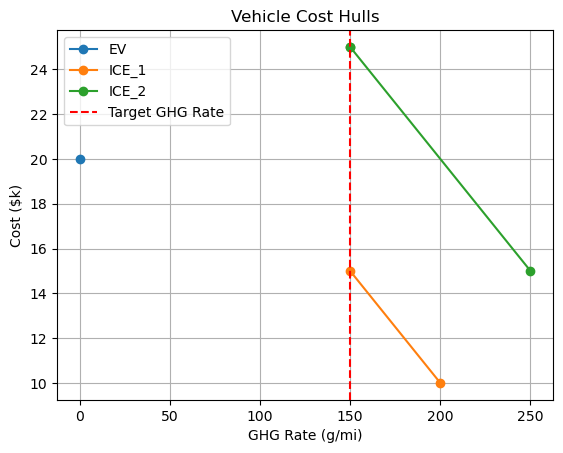

In [16]:
# Lets plot the cost hull
for vehicle_id in dummy_vehicle_data[None]['vehicle_set'][None]:
    costs = [dummy_vehicle_data[None]['technology_costs'][(vehicle_id, tech)] for tech in dummy_vehicle_data[None]['technology_set'][vehicle_id]]
    ghg_rates = [dummy_vehicle_data[None]['technology_ghg_rates'][(vehicle_id, tech)] for tech in dummy_vehicle_data[None]['technology_set'][vehicle_id]]
    
    # Connect points via a line
    plt.plot(ghg_rates, costs, label=f'{vehicle_id}', marker='o')

plt.axvline(x=150, color='r', linestyle='--', label=f'Target GHG Rate')

# Add labels and legend
plt.xlabel('GHG Rate (g/mi)')
plt.ylabel('Cost ($k)')
plt.legend()
plt.title('Vehicle Cost Hulls')
plt.grid(True)
plt.show()

In [17]:
# Build model
model = pyo.AbstractModel()

# Define Sets
model.vehicle_set = pyo.Set()
model.technology_set = pyo.Set(model.vehicle_set)

# Initialize technology set
def init_vehicle_technology_set (model):
    return ((vehicle_id, technology_id) for vehicle_id in model.vehicle_set for technology_id in model.technology_set[vehicle_id])

model.vehicle_technology_set = pyo.Set(dimen=2, initialize=init_vehicle_technology_set)

# Define parameters
model.technology_costs = pyo.Param(model.vehicle_technology_set, within=pyo.NonNegativeReals)
model.technology_ghg_rates = pyo.Param(model.vehicle_technology_set, within=pyo.NonNegativeReals)
model.vehicle_target_ghg_rates = pyo.Param(model.vehicle_set, within=pyo.NonNegativeReals)
model.preference_parameters = pyo.Param() # utility
model.og_utility = pyo.Param()
model.market_size = pyo.Param()

# Define decision variables
model.var_vehicle_technologies = pyo.Var(model.vehicle_technology_set, domain=pyo.NonNegativeReals, bounds=(0,1))
model.var_vehicle_prices = pyo.Var(model.vehicle_set, domain=pyo.NonNegativeReals, bounds=(0,100))

# Supplementary rules
def vehicle_cost_rule(model,vehicle_id):
    vehicle_cost = sum(model.technology_costs[(vehicle_id, technology_id)] * model.var_vehicle_technologies[(vehicle_id, technology_id)]
                                                   for technology_id in model.technology_set[vehicle_id])
    return vehicle_cost

def vehicle_ghg_rate_rule(model,vehicle_id):
    vehicle_ghg_rate = sum(model.technology_ghg_rates[(vehicle_id, technology_id)] * model.var_vehicle_technologies[(vehicle_id, technology_id)]
                                                   for technology_id in model.technology_set[vehicle_id])
    return vehicle_ghg_rate

def vehicle_utility_rule(model,vehicle_id):
    utility = model.preference_parameters * model.var_vehicle_prices[vehicle_id]
    return utility

def vehicle_demand_rule(model,vehicle_id):
    vehicle_demand = pyo.exp(model.vehicle_utilities[vehicle_id]) / (sum(pyo.exp(model.vehicle_utilities[vehicle_id])for vehicle_id in model.vehicle_set) + pyo.exp(model.og_utility))
    return vehicle_demand

# Define intermediate vars
model.vehicle_costs = pyo.Expression(model.vehicle_set, rule = vehicle_cost_rule)
model.vehicle_ghg_rates = pyo.Expression(model.vehicle_set, rule = vehicle_ghg_rate_rule)
model.vehicle_utilities = pyo.Expression(model.vehicle_set, rule = vehicle_utility_rule)  # Calculate utility
model.vehicle_demands = pyo.Expression(model.vehicle_set, rule = vehicle_demand_rule)   # Caluclate demand

# Define objective
def profit_rule(model):
    profit = sum((model.var_vehicle_prices[vehicle_id] - model.vehicle_costs[vehicle_id]) * model.vehicle_demands[vehicle_id] for vehicle_id in model.vehicle_set)
    return profit

model.obj = pyo.Objective(rule=profit_rule, sense=pyo.maximize)

# Define constraints
def design_rules(model):
    return [1 - sum(model.var_vehicle_technologies[(vehicle_id, technology_id)] for technology_id in model.technology_set[vehicle_id]) == 0 for vehicle_id in model.vehicle_set]

def swa_ghg_rule(model):
    total_sales = sum(model.vehicle_demands[vehicle_id] for vehicle_id in model.vehicle_set)
    swa_ghg_rate = sum(model.vehicle_ghg_rates[vehicle_id]*model.vehicle_demands[vehicle_id] for vehicle_id in model.vehicle_set) / total_sales
    swa_target_rate = sum(model.vehicle_target_ghg_rates[vehicle_id]*model.vehicle_demands[vehicle_id] for vehicle_id in model.vehicle_set) / total_sales
    return swa_ghg_rate  - swa_target_rate <= 0

model.con_design_rule = pyo.ConstraintList(rule=design_rules)
model.con_swa_ghg_rule = pyo.Constraint(rule=swa_ghg_rule)

# Create an instance of the model
instance = model.create_instance(dummy_vehicle_data)

solver = pyo.SolverFactory('ipopt',executable='C:\\Ipopt\\bin\\ipopt.exe')
results = solver.solve(instance)
print(results)

action taken

Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 8
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.05453848838806152
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [18]:
print("Technologies:")
instance.var_vehicle_technologies.pprint()

# Print var_vehicle_prices
print("Prices:")
instance.var_vehicle_prices.pprint()

# Print results
print("Profit:", pyo.value(instance.obj))
results_swa_ghg = sum(pyo.value(instance.vehicle_ghg_rates[vehicle_id])*pyo.value(instance.vehicle_demands[vehicle_id]) for vehicle_id in instance.vehicle_set) \
    / sum(pyo.value(instance.vehicle_demands[vehicle_id])for vehicle_id in instance.vehicle_set)
print('SWA GHG Rate: ', results_swa_ghg)
results_list = []
for vehicle_id in instance.vehicle_set:
    price = pyo.value(instance.var_vehicle_prices[vehicle_id])
    vehicle_costs = pyo.value(instance.vehicle_costs[vehicle_id])
    ghg_rate = pyo.value(instance.vehicle_ghg_rates[vehicle_id])
    vehicle_demand = pyo.value(instance.vehicle_demands[vehicle_id])
    results_list.append({"Vehicle": vehicle_id, "Price": price, "Cost": vehicle_costs, "Demand": vehicle_demand, "GHG Rate": ghg_rate})
results_df = pd.DataFrame(results_list)
results_df['Price'] = results_df['Price'].round(3)
print(results_df)

Technologies:
var_vehicle_technologies : Size=5, Index=vehicle_technology_set
    Key                    : Lower : Value                 : Upper : Fixed : Stale : Domain
            ('EV', 'Base') :     0 :                   1.0 :     1 : False : False : NonNegativeReals
         ('ICE_1', 'Base') :     0 :     0.999999991203029 :     1 : False : False : NonNegativeReals
    ('ICE_1', 'Upgrade_1') :     0 : 8.796971006195143e-09 :     1 : False : False : NonNegativeReals
         ('ICE_2', 'Base') :     0 :    0.9999999919605012 :     1 : False : False : NonNegativeReals
    ('ICE_2', 'Upgrade_1') :     0 :   8.0394987951095e-09 :     1 : False : False : NonNegativeReals
Prices:
var_vehicle_prices : Size=3, Index=vehicle_set
    Key   : Lower : Value              : Upper : Fixed : Stale : Domain
       EV :     0 : 27.466442113117797 :   100 : False : False : NonNegativeReals
    ICE_1 :     0 :  23.61136424197316 :   100 : False : False : NonNegativeReals
    ICE_2 :     0 : 30.147594